### Étude de la molécule DMAC-DPS avec la base 6-31G et la fonctionnelle B3LYP 
Afin de pouvoir comparer les résultats avec ceux de références 

In [1]:
import rdkit

rdkit.__version__

'2023.09.6'

In [2]:
import os
import time
import datetime
import subprocess as sp
from pathlib import Path
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem import RDConfig
from rdkit import Chem
import os, sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from pyscf.data import nist
from pyscf import gto, scf, dft, tddft, sgx
from pyscf import solvent
from pyscf.lib import chkfile
from pyscf.tools import cubegen, molden

au2ev = nist.HARTREE2EV

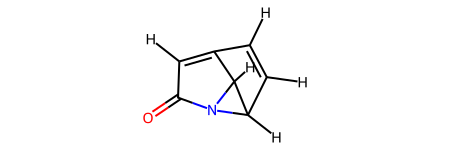

In [7]:
smi = 'O=C1C=C2C=CC3C2N13'
key = 'gdb_43243'
m = Chem.MolFromSmiles(smi)
mol = AllChem.AddHs(m)
mol

In [8]:
data = []

Molwt = Descriptors.ExactMolWt(mol)
Solubility = Descriptors.MolLogP(mol)
hbd = Descriptors.NumHDonors(mol)
hba = Descriptors.NumHAcceptors(mol)
tpsa = Descriptors.TPSA(mol)
mol_rdkit = m 
Sa_score = sascorer.calculateScore(mol_rdkit)
num_atoms = mol.GetNumAtoms()

molecular_properties = {
    'Molecule': key,
    'Molecular Weight': Molwt,
    'LogP': Solubility,
    'Hbd': hbd,
    'Hba': hba,
    'TPSA': tpsa,
    'SA-SCORE': Sa_score,
    'Number of atoms':num_atoms
}
data.append(molecular_properties)

df = pd.DataFrame(data)
df.set_index('Molecule', inplace=True)
df

,Molecular Weight,LogP,Hbd,Hba,TPSA,SA-SCORE,Number of atoms
Molecule,,,,,,,
gdb_43243,119.037114,0.0756,0,1,20.08,4.877976,14


In [9]:
import py3Dmol
py3Dmol.__version__

'2.4.2'

In [14]:
def view3D(mol, label, fmt='mol'):
        """3D vizualisation of mol/xyz file with Py3DMol
        """

        view = py3Dmol.view(width=400, height=400)

        if fmt=='mol':
            view.addModel(Chem.MolToMolBlock(mol), fmt)
        elif fmt=='xyz':
            view.addModel(mol, fmt)

        view.setStyle({'stick': {}, 'sphere': {'scale': .30}})
        view.addLabel(label, {'position': {'x': -2, 'y': -6, 'z': 0}})
        view.zoomTo()
        view.show()

view3D(mol, f'{key}_3D.png')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
# Verify if the "data2402_{key}" subdirectory exist and if not, create it
working_dir = Path(f'./Result2504/{key}')
# Create the output directory if it doesn't exist
working_dir.mkdir(parents=True, exist_ok=True)

In [16]:
path_xyz = working_dir / f'{key}.xyz'

In [17]:
def generate_3d_rdkit_conformation(key, smi, working_dir):
    """Generate RDKit 3D optimized conformation of a molecule from smiS
        and store the xyz coordinates in a file

    Args:
        smi (str): The smiS string of the molecule
        working_dir (Path): The directory path where results of calculations will be saved

    Returns:
        mol_xyz (str): xyz coordinates of the RDKit molecule object
        with optimized 3D conformation

    """
    # key = smi.replace('/', '_')
    
    
    if not smi:
        raise ValueError("Invalid smiS string")

    if not path_xyz.exists():
        # Defines a molecule from its smiS string
        mol_rdkit = Chem.MolFromSmiles(smi)

        # Add explicit Hs
        mol_rdkit = Chem.AddHs(mol_rdkit)

        # Generates the initial 3D conformation of the molecule
        AllChem.EmbedMolecule(mol_rdkit)

        # Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
        AllChem.MMFFOptimizeMolecule(mol_rdkit, maxIters=200, mmffVariant="MMFF94s")

        # Canonicalize the orientation of the conformation
        Chem.rdMolTransforms.CanonicalizeMol(mol_rdkit, normalizeCovar=True, ignoreHs=False)

        # Convert RDKit molecule to XYZ format
        mol_xyz = Chem.MolToXYZBlock(mol_rdkit)

        # try:
        #     path_xyz.parent.mkdir(parents=True, exist_ok=True)
        #     with path_xyz.open("w") as f:
        #         f.write(mol_xyz)
        # except Exception as e:
        #     print(f"Error occurred while writing the XYZ file: {e}")
        #     return None
        with open(path_xyz, "w") as f:
            f.write(mol_xyz)
    else:
        with path_xyz.open("r") as f:
            mol_xyz = f.read()
            

    # Remove the first line (number of atoms) from XYZ data
    # mol_xyz = '\n'.join(mol_xyz.strip().split('\n')[1:])

    return mol_xyz,mol

In [19]:
mol_xyz, mol = generate_3d_rdkit_conformation(key, smi, working_dir)

ValueError: Bad Conformer Id

In [12]:
xtb_processP = sp.run(['xtb', path_xyz, '--gfn', '2', '--alpb', 'toluene', '--opt', 'vtight', 'nproc --ignore=2'])

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.7.0 (08769fc) compiled by 'albert@albert-system' on 2024-03-04

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY;

normal termination of xtb


In [13]:
# Best conformation search with CREST
sp.run(['crest', 'xtbopt.xyz', '--gfn2','alpb', 'toluene', '--mquick', '--noreftopo', '-T2', 'nproc --ignore=2'])

 
       ╔════════════════════════════════════════════╗
       ║            ___ ___ ___ ___ _____           ║
       ║           / __| _ \ __/ __|_   _|          ║
       ║          | (__|   / _|\__ \ | |            ║
       ║           \___|_|_\___|___/ |_|            ║
       ║                                            ║
       ║  Conformer-Rotamer Ensemble Sampling Tool  ║
       ║          based on the xTB methods          ║
       ║                                            ║
       ╚════════════════════════════════════════════╝
       Version 3.0.1, Mon May  6 18:43:33 UTC 2024
       commit (1782d7d) compiled by 'runner@fv-az772-53'
 
   Cite work conducted with this code as

   • P.Pracht, F.Bohle, S.Grimme, PCCP, 2020, 22, 7169-7192.
   • S.Grimme, JCTC, 2019, 15, 2847-2862.
   • P.Pracht, S.Grimme, C.Bannwarth, F.Bohle, S.Ehlert,
     G.Feldmann, J.Gorges, M.Müller, T.Neudecker, C.Plett,
     S.Spicher, P.Steinbach, P.Wesołowski, F.Zeller,
     J. Chem. Phys., 2024, 160, 11

CompletedProcess(args=['crest', 'xtbopt.xyz', '--gfn2', 'alpb', 'toluene', '--mquick', '--noreftopo', '-T2', 'nproc --ignore=2'], returncode=0)

In [14]:
xtb_process = sp.run(['xtb', 'crest_best.xyz', '--gfn', '2', '--alpb', 'toluene', '--opt', 'vtight', 'nproc', '--ignore=2'])


      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.7.0 (08769fc) compiled by 'albert@albert-system' on 2024-03-04

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY;

normal termination of xtb


In [15]:
path_xtb_xyz = working_dir / f'{key}_xtb.xyz'
path_xtb_opt_log = working_dir / f'{key}_xtb_opt.log'
path_xtb_Pre_opt_log = working_dir / f'{key}_xtb_Pre_opt.log'
path_xtb_opt = working_dir / f'{key}_xtb-crest_optimization'

In [16]:
!cp xtbopt.xyz {path_xtb_xyz}

In [17]:
with open(path_xtb_xyz, 'r') as f:
    mol_xtb_xyz = f.read()
lines = mol_xtb_xyz.strip().split('\n')
mol_xtb_xyz = '\n'.join(lines[:1] + [''] + lines[2:])

In [18]:
blocklines2='\n'.join(mol_xtb_xyz.strip().split('\n')[1:])
print(blocklines2)


C            5.79081024759104       -3.46310625292905        1.00424011275157
C            5.58750134577622       -2.50815411799166       -0.18787119133794
C            4.11598360281186       -2.50918364921736       -0.56120058003139
C            3.50895872271935       -3.70076746190524       -0.93845144295203
C            2.16699939649637       -3.77304394404711       -1.26274961112882
C            1.39246017652149       -2.62916030904741       -1.19365400419010
C            1.96894530127291       -1.43310778143144       -0.81818735009245
C            3.33311631465729       -1.35090808819693       -0.52169436159776
N            3.89150566208992       -0.12776857602563       -0.16080235946328
C            5.23136555416797       -0.00693648048564        0.19200230052266
C            5.75282219048805        1.25205115405525        0.50375834896118
C            7.07548029286461        1.40271678804847        0.86527862026732
C            7.90618430896903        0.29756747904562        0.

In [2]:
import pandas.util 
import pandas as pd
# Read the CSV file,
df1 = pd.read_pickle("PCE_paper_GDB9.pkl")


In [3]:
df1


,smiles_key,smiles,HOMO,LUMO,Gap,HOMO(eV),LUMO(eV),Gap(eV),Scharber_Gap(eV),voc_pcbm(V),jsc_pcbm(A.m-2),pce_pcbm(%),voc_pcdtbt(V),jsc_pcdtbt(A.m-2),pce_pcdtbt(%),sas1(%),pce_pcbm_sas(%),pce_pcdtbt_sas(%)
0,gdb 326,O=CC(=O)C=O,-0.2606,-0.1455,0.1151,-7.091287,-3.959257,3.132031,3.132031,2.491287,6.491318,1.167778,1.240743,6.491318,0.581592,5.395479,-4.227701,-4.813887
1,gdb 723,C1=NN=CN=N1,-0.2475,-0.1121,0.1355,-6.734818,-3.050396,3.687143,3.687143,2.134818,1.283422,0.197849,2.149604,0.000000,0.000000,5.968223,-5.770374,-5.968223
2,gdb 1587,CC(=O)C(=O)C=O,-0.2489,-0.1149,0.1340,-6.772914,-3.126588,3.646326,3.646326,2.172914,1.458933,0.228919,2.073412,0.000000,0.000000,5.829075,-5.600157,-5.829075
3,gdb 1589,NC(=O)C(=O)C=O,-0.2482,-0.1217,0.1265,-6.753866,-3.311626,3.442240,3.442240,2.153866,2.710627,0.421592,1.888374,0.000000,0.000000,5.567027,-5.145435,-5.567027
4,gdb 2115,O=C1CC=CC1=O,-0.2347,-0.0951,0.1396,-6.386512,-2.587803,3.798709,3.798709,1.786512,0.897541,0.115788,2.612197,0.000000,0.000000,6.078272,-5.962484,-6.078272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,gdb 133853,OC12C3C1N1CC3N=C21,-0.2087,-0.0889,0.1198,-5.679016,-2.419092,3.259924,3.259924,1.079016,4.574106,0.356400,2.780908,0.000000,0.000000,7.936935,-7.580535,-7.936935
520,gdb 133854,CC12CC34CC=C(C13)C24,-0.1575,-0.0912,0.0663,-4.285793,-2.481678,1.804115,1.804115,0.000000,107.475925,0.000000,2.718322,0.000000,0.000000,8.603759,-8.603759,-8.603759
521,gdb 133858,CC1N2C3C4=CCC13C24,-0.1693,-0.1041,0.0652,-4.606888,-2.832705,1.774182,1.774182,0.006888,112.519999,0.055963,2.367295,0.000000,0.000000,8.659636,-8.603672,-8.659636
522,gdb 133864,C1C2CC3OC4CC1C234,-0.1386,-0.0638,0.0747,-3.771498,-1.736086,2.032691,2.032691,0.000000,73.827381,0.000000,3.463914,0.000000,0.000000,8.154107,-8.154107,-8.154107


In [10]:
# Création des DataFrames avec colonne 'type'
df_acc = (
    df1[df1["pce_pcbm(%)"] > 1.0]
    [["smiles_key", "smiles"]]
    .assign(type='accepteur')  # Ajout de la colonne type
)

df_don = (
    df1[df1["pce_pcdtbt(%)"] > 1.0]
    [["smiles_key", "smiles"]]
    .assign(type='donneur')    # Ajout de la colonne type
)

# Concaténation et traitement des doublons
my1_df = (
    pd.concat([df_acc, df_don], ignore_index=True)
    .groupby(['smiles_key', 'smiles'], as_index=False)
    .agg({
        'type': lambda x: 'donneur/accepteur' if len(x) > 1 else x.iloc[0]
    })
)

my1_df

,smiles_key,smiles,type
0,gdb 117026,CNCC(=O)C(=O)C#N,accepteur
1,gdb 117032,CCNC(=N)C(=O)C=O,accepteur
2,gdb 130518,O1N=CN=C2C=NC=C12,accepteur
3,gdb 130536,O1N=NC=C2C=NC=C12,accepteur
4,gdb 133337,NC1=C(F)ON=NC1=N,accepteur
5,gdb 26187,CC([NH3+])C1=CC([O-])=CO1,accepteur
6,gdb 30706,CC1=C(C[NH3+])OC=C1[O-],accepteur
7,gdb 326,O=CC(=O)C=O,accepteur
8,gdb 32866,C[NH2+]CC1=CC([O-])=CO1,accepteur
9,gdb 37079,C1C2=CC3C=C1C1C2N31,accepteur


In [12]:
def pyscf_molecule_object(key, smi, working_dir, basis='6-31G(d,p)'):
    """
    Crée un objet molécule PySCF à partir d'un smiS.
    
    Args:
        smi_key (str): Clé smiS
        smi (str): Chaîne smiS
        working_dir (str): Répertoire de travail
        basis (str, optional): Ensemble de base à utiliser, par défaut '631g*'
    
    Returns:
        pyscf.gto.Mole: Objet molécule PySCF
    """

    mol_pyscf = gto.Mole()
    mol_pyscf.build(
        atom=blocklines2,
        basis=basis,
        symmetry=True,
        unit='Angstrom'
    )
    
    return mol_pyscf



In [20]:
def tddft_osc_strength_calculations(key, smi, working_dir):
    """PySCF TDDFT-TDA calculations of fluorescence energy,
    singlet-triplet gap and oscillator strength

    Part of code is from https://github.com/aspuru-guzik-group/Tartarus

    Args:
        key (str): key
        smi (str): The smi string of the molecule
        working_dir (str): The directory path where results of calculations will be saved
        phase (str) : 'gas' for the gas-phase or 'sol' for solvation

    """

     # PySCF molecule object
    mol_pyscf = pyscf_molecule_object(key, smi, working_dir, basis = '6-31G(d,p)')

    #=====================================
    # DFT CALCULATIONS
    #=====================================

   # Setting path for DFT results, chkfile and analyze object
    path_results = os.path.join(working_dir, f'Results_{key}.csv')
    path_DFT_chk = os.path.join(working_dir, f'{key}_DFT.chk')
    path_DFT_txt = os.path.join(working_dir, f'{key}_DFT.txt')

    mol_pyscf.output = path_DFT_txt

    # Singlets GS DFT calculations
    mdft = dft.RKS(mol_pyscf).apply(solvent.ddCOSMO)
    mdft.xc = 'B3LYP'
    mdft.with_solvent.eps = 2.3741  # toluene
    mdft.max_cycle = 512
    mdft.grids.level = 0
    mdft.conv_tol = 1E-7
    # if phase == 'sol':
    #     mdft = mdft.ddCOSMO()
    #     mdft.with_solvent.eps = 2.3741   # Toluene
    # mdft.density_fit(auxbasis='def2-universal-jkfit')

    if os.path.exists(path_DFT_chk):
        path_DFT_status = f'{path_DFT_chk} exist'
        start = time.time()

        # Load the DFT results from the checkpoint file
        mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
        mdft.kernel()

        elapsed_DFT = str(datetime.timedelta(
            seconds = time.time() - start))
    else:
        path_DFT_status = f'{path_DFT_chk} don\'t exist'
        start = time.time()

        # Save the DFT results to a checkpoint file
        mdft.chkfile = path_DFT_chk
        mdft.kernel()
        if(not mdft.converged):
            mdft = mdft.newton(mdft)
            mdft.kernel()

        elapsed_DFT = str(datetime.timedelta(
            seconds = time.time()- start))

    # Analyze the given DFT object
    mdft.analyze()

    # Index of HOMO and LUMO
    homo_idx = np.where(mdft.mo_occ > 0)[0][-1]
    lumo_idx = np.where(mdft.mo_occ == 0)[0][0]

    # Create the DFT results dataframe
    list_results_DFT = [mdft.e_tot,
                        mdft.energy_elec()[0],
                        mdft.energy_nuc(),
                        mdft.mo_energy[homo_idx],
                        mdft.mo_energy[lumo_idx]]
    dict_results_DFT = {'Hartree': list_results_DFT,
                    'eV': [x * au2ev for x in list_results_DFT]}
    df_DFT = pd.DataFrame(dict_results_DFT,
                        index = ['Total energy',
                                 'Electronic energy',
                                 'Nuclear repulsion energy',
                                 'MO energy of HOMO',
                                 'MO energy of LUMO'])
    return df_DFT,mdft,path_results,elapsed_DFT,path_DFT_status


In [21]:
df_DFT,mdft,path_results,elapsed_DFT,path_DFT_status=tddft_osc_strength_calculations(key, df1, working_dir)

/home/mvotokps/anaconda3/envs/Partick/lib/python3.12/site-packages/pyscf/dft/libxc.py:1110: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -2280.39211475503
**** MO energy ****
MO #1   energy= -89.1017687235101  occ= 2
MO #2   energy= -19.1444249765662  occ= 2
MO #3   energy= -19.1443287182632  occ= 2
MO #4   energy= -14.3748934426012  occ= 2
MO #5   energy= -14.3739514029638  occ= 2
MO #6   energy= -10.2471290642672  occ= 2
MO #7   energy= -10.2469247863148  occ= 2
MO #8   energy= -10.2304614217732  occ= 2
MO #9   energy= -10.2298747169679  occ= 2
MO #10  energy= -10.229732668041   occ= 2
MO #11  energy= -10.2292631930278  occ= 2
MO #12  energy= -10.2284952265642  occ= 2
MO #13  energy= -10.2281785756892  occ= 2
MO #14  energy= -10.216510019516   occ= 2
MO #15  energy= -10.2164541364941  occ= 2
MO #16  energy= -10.2162498293404  occ= 2
MO #17  energy= -10.2160325909702  occ= 2
MO #18  energy= -10.2114150384297  occ= 2
MO #19  energy= -10.2112718437785  occ= 2
MO #20  energy= -10.2110838453091  occ= 2
MO #21  energy= -10.2108301064515  occ= 2
MO #22  energy= -10.2048273849674  occ= 2
MO #23  energy=

In [22]:
df_DFT

,Hartree,eV
Total energy,-2280.392115,-62052.630112
Electronic energy,-8141.255728,-221534.852304
Nuclear repulsion energy,5860.863613,159482.222193
MO energy of HOMO,-0.186250,-5.068122
MO energy of LUMO,-0.062506,-1.700886


In [23]:
mdft

In [24]:
path_results

'Result2407/DMAC-DPS/Results_DMAC-DPS.csv'

In [25]:
elapsed_DFT

'0:49:46.473012'

In [26]:
path_DFT_status

'Result2407/DMAC-DPS/DMAC-DPS_DFT.chk exist'

In [29]:
def tda_osc_strength_calculations(key, smi, mdft, path_results, elapsed_DFT, path_DFT_status, df_DFT, working_dir):
    
    mftda = tddft.TDA(mdft).apply(solvent.ddCOSMO)
    mdft.with_solvent.eps = 2.3741  # toluene
    mftda.nstates = 2
    # if phase == 'sol':
    #     mftda = mftda.ddCOSMO()
    #     mftda.with_solvent.eps = 2.3741   # Toluene
    #     mftda.with_solvent.equilibrum_solvation = True

    # Setting path for singlets TDDFT-TDA chkfile
    path_TDA_chk = os.path.join(working_dir, f'{key}_TDA.chk')

    if os.path.exists(path_TDA_chk):
        path_TDA_status = f'{path_TDA_chk} exist'
        start = time.time()

        # Load the TDA singlet results from the checkpoint file
        mftda.__dict__.update(chkfile.load(path_TDA_chk, 'tddft'))
        E_TDA = mftda.kernel()

        elapsed_TDA = str(datetime.timedelta(
            seconds=time.time() - start))
    else:
        path_TDA_status = f'{path_TDA_chk} don\'t exist'
        start = time.time()

        # Save the TDA singlet results to a checkpoint file
        mftda.chkfile = path_TDA_chk
        E_TDA = mftda.kernel()
        #if(not mftda.converged):
        #    mftda = tddft.TDA.newton(mftda)
        #    E_TDA = mftda.kernel()

        elapsed_TDA = str(datetime.timedelta(
            seconds=time.time() - start))

    # Singlet excitation energies
    ee_singlets = mftda.e

    # Singlet oscillators strength
    OS_singlets = mftda.oscillator_strength(gauge='length')

    # Triplets ES TDDFT calculations with Tamm-Dancoff-approximation
    #==================================
    mftda.singlet = False

    # Setting path for triplets TDDFT-TDA chkfile
    path_TDA3_chk = os.path.join(working_dir, f'{key}_TDA3.chk')

    if os.path.exists(path_TDA3_chk):
        path_TDA3_status = f'{path_TDA3_chk} exist'
        start = time.time()

        # Load the TDA triplet results from the checkpoint file
        mftda.__dict__.update(chkfile.load(path_TDA3_chk, 'tddft'))
        E_TDA3 = mftda.kernel()

        elapsed_TDA3 = str(datetime.timedelta(
            seconds=time.time() - start))
    else:
        path_TDA3_status = f'{path_TDA3_chk} don\'t exist'
        start = time.time()

        # Save the TDA results to a checkpoint file
        mftda.chkfile = path_TDA3_chk
        E_TDA3 = mftda.kernel()

        elapsed_TDA3 = str(datetime.timedelta(
            seconds=time.time() - start))

    # Triplet excitation energies
    ee_triplets = mftda.e

    # Sought results
    #==================================
    #
    # fluorescence energy
    f_energy = min(ee_singlets)

    # Singlet-Tiplet gap
    gap_ST = min(ee_singlets) - min(ee_triplets)

    # Oscillator strength
    OStr = OS_singlets[0]

    # Lifetime calculation in au
    c = nist.LIGHT_SPEED # in au
    time_au = 2.4188843265857E-17 # in au

    tau_au = c**3 / (2 * (f_energy)**2 * OStr)
    tau = tau_au * time_au

    # Multi-Objective function
    mobj = OStr - gap_ST * au2ev - np.abs(f_energy * au2ev - 3.2)

    #=====================================
    # DataFrame and saving in file
    #=====================================

    # Create the results dataframe
    list_results_TDA = [f_energy, gap_ST, OStr, tau, mobj]
    dict_results_TDA = {'a.u.': list_results_TDA,
                        'eV/ns': [f_energy * au2ev,
                                gap_ST * au2ev,
                                OStr,
                                tau * 1E+9,
                                mobj]}

    df_TDA = pd.DataFrame(dict_results_TDA,
                        index=['Fluorescence energy',
                                'Singlet-Triplet gap',
                                'Oscillator strength',
                                'Lifetime',
                                'Multi-Obj'])

    # Save the DFT and TDDFT-TDA results dataframe to a file

    with open(path_results, "a") as f:
        f.write(f"\n\nDFT calculations of {key} obtained in; \
            {elapsed_DFT}s ; as {path_DFT_status} \n")
        df_DFT.to_csv('patrick1.csv')

        f.write(f"\n\nTDDFT-TDA calculations of {key} obtained in; \
                {elapsed_TDA}s ; as {path_TDA_status}\n \
                {elapsed_TDA3}s ; as {path_TDA3_status}\n")
        df_TDA.to_csv('elvis.csv')
        return df_TDA

In [30]:
df_TDA=tda_osc_strength_calculations(key, smi, mdft, path_results, elapsed_DFT, path_DFT_status, df_DFT, working_dir)

Excited State energies (eV)
[2.77429255 2.81403769]
Excited State energies (eV)
[2.71918398 2.74717207]


In [31]:
df_TDA

,a.u.,eV/ns
Fluorescence energy,1.019534e-01,2.774293
Singlet-Triplet gap,2.025202e-03,0.055109
Oscillator strength,2.856286e-02,0.028563
Lifetime,1.048297e-07,104.829664
Multi-Obj,-4.522532e-01,-0.452253


In [35]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from pyscf import gto, dft, tddft, solvent
from pyscf.lib import chkfile
from pyscf.data import nist

# Conversion factor from atomic units to eV
au2ev = 27.211386245988

def tddft_osc_strength_calculations(key, xyz_file, working_dir):
    """PySCF TDDFT-TDA calculations for a single molecule"""
    try:
        # Create working directory if it doesn't exist
        os.makedirs(working_dir, exist_ok=True)
        
        # Read XYZ file
        with open(xyz_file, 'r') as f:
            xyz_data = f.readlines()
        
        # Extract atom symbols and coordinates
        atoms = []
        coords = []
        for line in xyz_data[2:]:  # Skip first two lines
            parts = line.split()
            if len(parts) >= 4:
                atoms.append(parts[0])
                coords.append([float(x) for x in parts[1:4]])
        
        # Create PySCF molecule object
        mol_pyscf = gto.Mole()
        mol_pyscf.atom = list(zip(atoms, coords))
        mol_pyscf.basis = '6-31G(d,p)'
        mol_pyscf.build()
        
        # DFT calculations with solvation
        path_DFT_chk = os.path.join(working_dir, f'{key}_DFT.chk')
        mdft = dft.RKS(mol_pyscf).apply(solvent.ddCOSMO)
        mdft.xc = 'B3LYP'
        mdft.with_solvent.eps = 2.3741  # toluene
        mdft.max_cycle = 512
        mdft.grids.level = 0
        mdft.conv_tol = 1E-7
        
        start = time.time()
        if os.path.exists(path_DFT_chk):
            mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
        mdft.kernel()
        if not mdft.converged:
            mdft = mdft.newton(mdft)
            mdft.kernel()
        elapsed_DFT = str(datetime.timedelta(seconds=time.time() - start))
        
        # TDDFT calculations
        path_TDDFT_chk = os.path.join(working_dir, f'{key}_TDDFT.chk')
        mtd = tddft.TDA(mdft).apply(solvent.ddCOSMO)
        mtd.with_solvent.eps = 2.3741
        mtd.nstates = 5
        
        start = time.time()
        if os.path.exists(path_TDDFT_chk):
            mtd.__dict__.update(chkfile.load(path_TDDFT_chk, 'tddft'))
        mtd.kernel()
        elapsed_TDDFT = str(datetime.timedelta(seconds=time.time() - start))
        
        # Calculate excited state properties
        fluorescence_energy = mtd.e[0] if len(mtd.e) > 0 else np.nan
        oscillator_strength = mtd.oscillator_strength(gauge='length')[0] if len(mtd.e) > 0 else np.nan
        
        # Triplet calculations
        mtd_triplet = tddft.TDA(mdft).apply(solvent.ddCOSMO)
        mtd_triplet.with_solvent.eps = 2.3741
        mtd_triplet.nstates = 1
        mtd_triplet.singlet = False
        
        try:
            mtd_triplet.kernel()
            triplet_energy = mtd_triplet.e[0] if len(mtd_triplet.e) > 0 else np.nan
            singlet_triplet_gap = fluorescence_energy - triplet_energy
        except:
            triplet_energy = np.nan
            singlet_triplet_gap = np.nan
        
        # Lifetime calculation
        c = nist.LIGHT_SPEED  # in au
        time_au = 2.4188843265857E-17  # in au
        tau_au = c**3 / (2 * (fluorescence_energy)**2 * oscillator_strength) if fluorescence_energy and oscillator_strength else np.nan
        tau = tau_au * time_au if not np.isnan(tau_au) else np.nan
        
        # Multi-Objective function
        mobj = (oscillator_strength - singlet_triplet_gap * au2ev - 
                np.abs(fluorescence_energy * au2ev - 3.2)) if all(not np.isnan(x) for x in [oscillator_strength, singlet_triplet_gap, fluorescence_energy]) else np.nan
        
        return {
            'Molecule': key,
            'Fluorescence_energy_eV': fluorescence_energy * au2ev,
            'Singlet_Triplet_gap_eV': singlet_triplet_gap * au2ev,
            'Oscillator_strength': oscillator_strength,
            'Total_energy_eV': mdft.e_tot * au2ev,
            'Electronic_energy_eV': mdft.energy_elec()[0] * au2ev,
            'Nuclear_repulsion_energy_eV': mdft.energy_nuc() * au2ev,
            'Lifetime_ns': tau * 1e9 if not np.isnan(tau) else np.nan,
            'Multi_Obj': mobj,
            'DFT_calculation_time': elapsed_DFT,
            'TDDFT_calculation_time': elapsed_TDDFT,
            'Status': 'Success'
        }
    except Exception as e:
        return {
            'Molecule': key,
            'Status': f'Failed: {str(e)}'
        }

def calculate_all_molecules(molecule_ids, base_xyz_path, working_dir):
    """Calculate properties for all molecules and return combined DataFrame"""
    all_results = []
    
    for mol_id in molecule_ids:
        key = f"gdb_{mol_id}"
        xyz_file = os.path.join(base_xyz_path, f"gdb{mol_id}_xtb1_opt.xyz")
        
        if os.path.exists(xyz_file):
            print(f"Processing {key}...")
            result = tddft_osc_strength_calculations(key, xyz_file, working_dir)
            all_results.append(result)
        else:
            print(f"XYZ file not found for {key}")
            all_results.append({
                'Molecule': key,
                'Status': 'Failed: XYZ file not found'
            })
    
    # Create DataFrame from all results
    df_results = pd.DataFrame(all_results)
    
    # Save combined results
    combined_csv_path = os.path.join(working_dir, 'combined_results.csv')
    df_results.to_csv(combined_csv_path, index=False)
    
    return df_results

# Example usage
molecule_ids = [43243, 21398, 66499, 8723]
base_xyz_path = "./xTB_OPT_XYZ"
working_dir = "./calculation_results"

df_all_results = calculate_all_molecules(molecule_ids, base_xyz_path, working_dir)
print(df_all_results)

Processing gdb_43243...
converged SCF energy = -399.6386067377
Excited State energies (eV)
[3.56077074 3.74531412 4.00351483 4.90371206 5.27491583]
Excited State energies (eV)
[1.96408606]
Processing gdb_21398...
converged SCF energy = -389.778780077232
Excited State energies (eV)
[0.91413823 2.53467709 3.16793227 3.25344643 3.61095149]
Excited State energies (eV)
[0.28221439]
Processing gdb_66499...
converged SCF energy = -436.63970953785
Excited State energies (eV)
[1.84647944 2.70041932 3.11307864 3.42166797 4.3406517 ]
Processing gdb_8723...
converged SCF energy = -454.4854673404
Excited State energies (eV)
[2.62529051 2.80723614 3.70850017 4.1394495  4.36089149]
Excited State energies (eV)
[2.11518453]
    Molecule  Fluorescence_energy_eV  Singlet_Triplet_gap_eV  \
0  gdb_43243                3.560771                1.596685   
1  gdb_21398                0.914138                0.631924   
2  gdb_66499                1.846479                     NaN   
3   gdb_8723               

In [32]:
pip install geometric

Note: you may need to restart the kernel to use updated packages.


smiles donneurs

0 43243	O=C1C=C2C=CC3C2N13	
1	21398	N=C1N=CN=NC=N1	
2	66499	OC12C3C1C1=NC2C3O

accepteur

0	8723	O=CC(=O)C(=O)C=O	
1	21398	N=C1N=CN=NC=N1


In [36]:
df_all_results 

,Molecule,Fluorescence_energy_eV,Singlet_Triplet_gap_eV,Oscillator_strength,Total_energy_eV,Electronic_energy_eV,Nuclear_repulsion_energy_eV,Lifetime_ns,Multi_Obj,DFT_calculation_time,TDDFT_calculation_time,Status
0,gdb_43243,3.560771,1.596685,0.019128,-10874.720487,-22236.661432,11361.940945,95.022058,-1.938327,0:00:22.550820,0:00:43.613138,Success
1,gdb_21398,0.914138,0.631924,0.001134,-10606.420935,-19956.162478,9349.741543,24314.546967,-2.916651,0:00:15.948579,0:00:23.528575,Success
2,gdb_66499,1.846479,NaN,0.008308,-11881.571787,-24346.793093,12465.221306,813.588855,NaN,0:00:24.012219,0:00:51.021566,Success
3,gdb_8723,2.625291,0.510106,0.000297,-12367.179595,-21449.196909,9082.017314,11252.298616,-1.084518,0:00:11.109612,0:00:20.088619,Success
